In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   195M      0  0:00:04  0:00:04 --:--:--  195M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [5]:
!ls PetImages

Cat  Dog


In [6]:
# prompt: Kiểm tra số lượng sample trong tập data

import os

# Path to the directory containing the image data
data_dir = 'PetImages'

# Initialize counters for each class
cat_count = 0
dog_count = 0

# Iterate over the subdirectories (Cat and Dog)
for subdir in os.listdir(data_dir):
  subdir_path = os.path.join(data_dir, subdir)
  if os.path.isdir(subdir_path):
    if subdir == 'Cat':
      for file in os.listdir(subdir_path):
        if file.endswith('.jpg'):  # Check for JPG files
          cat_count += 1
    elif subdir == 'Dog':
      for file in os.listdir(subdir_path):
        if file.endswith('.jpg'):  # Check for JPG files
          dog_count += 1
    else:
        print("Found unexpected subdirectory:", subdir)


print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")
print(f"Total number of images: {cat_count + dog_count}")


Number of cat images: 12500
Number of dog images: 12500
Total number of images: 25000


In [7]:
# prompt: kiểm tra shape của ảnh

import cv2

def check_image_shape(image_path):
  try:
    img = cv2.imread(image_path)
    if img is not None:
      print(f"Shape of image {image_path}: {img.shape}")
      return img.shape
    else:
      print(f"Could not read image: {image_path}")
      return None
  except Exception as e:
    print(f"Error processing image {image_path}: {e}")
    return None

# Example usage (replace with your image path):
image_path = 'PetImages/Dog/67.jpg'
check_image_shape(image_path)

Shape of image PetImages/Dog/67.jpg: (400, 400, 3)


(400, 400, 3)

In [ ]:
num_skipped = 0# biến đếm số lượng hình ảnh bị xóa
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)#kiểm tra xem chuỗi “JFIF” có xuất hiện trong 10 byte đầu tiên của tệp hay không. 
        finally:
            fobj.close()#đóng để giải phóng tài nguyên, khóa tệp tin để tránh tình trạng một ctr nào đó bị ngăn cản khi truy cập vào tệp tin chưa đc đóng

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


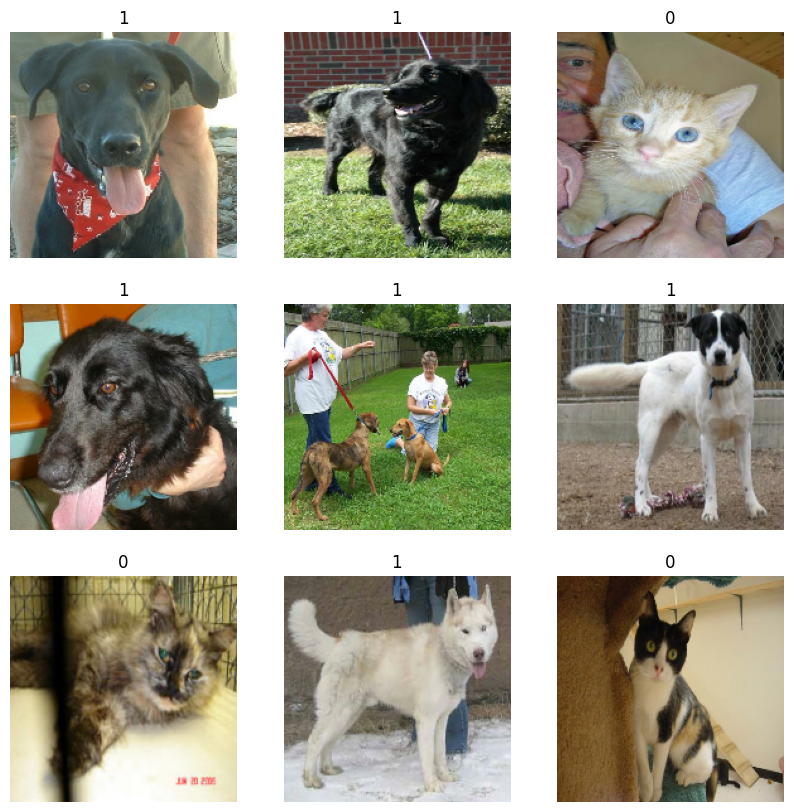

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),#thực hiện viêkc lật ngẫu nhiên các hình ảnh theo chiều ngang
    layers.RandomRotation(0.1),#xoay ngẫu nhiên với 10% của đường tròn
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

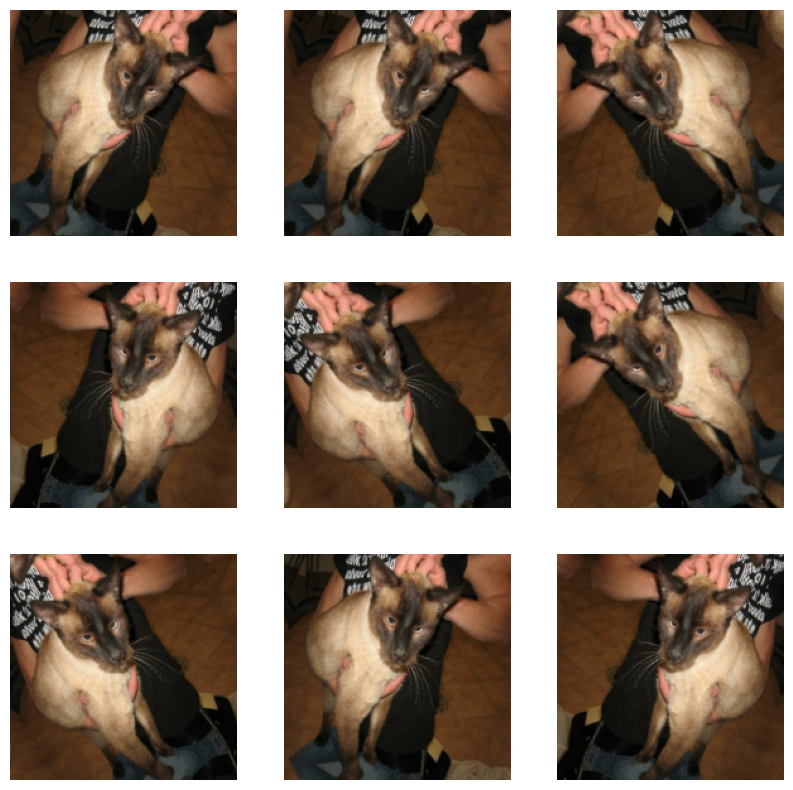

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Two options to preprocess the data
Option 1: Make it part of the model, like this:

Với tùy chọn này, việc tăng cường dữ liệu của bạn sẽ diễn ra trên thiết bị, đồng bộ với phần còn lại của quá trình thực thi mô hình, nghĩa là nó sẽ được hưởng lợi từ khả năng tăng tốc GPU.

Lưu ý rằng tính năng tăng cường dữ liệu không hoạt động tại thời điểm thử nghiệm, do đó, các mẫu đầu vào sẽ chỉ được tăng cường trong fit() chứ không phải khi gọi đánh giá() hoặc dự đoán().

Nếu bạn đang đào tạo về GPU, đây có thể là một lựa chọn tốt.

In [ ]:
#
input_shape = (180, 180)
inputs = keras.Input(shape=input_shape)#tạo lớp đầu vào cho mô hình Keras giúp xác định rõ ràng 
#kích thước đầu vào,dễ kiểm soát hơn, tích hợp tốt với Keras API
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this: 
Code như sau:

''
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
''

Với tùy chọn này, việc tăng cường dữ liệu của bạn sẽ diễn ra trên CPU, không đồng bộ và sẽ được lưu vào bộ đệm trước khi đi vào mô hình.

Nếu bạn đang đào tạo về CPU thì đây là tùy chọn tốt hơn vì nó làm cho việc tăng cường dữ liệu không đồng bộ và không bị chặn.

Trong trường hợp của chúng tôi, chúng tôi sẽ chọn tùy chọn thứ hai. Nếu bạn không chắc chắn nên chọn cái nào thì tùy chọn thứ hai (xử lý trước không đồng bộ) này luôn là một lựa chọn chắc chắn.

In [ ]:
#Preprocess the data  
# áp dụng tăng cường dữ liệu trên từng sample của tập training
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
#
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    #Khối đầu vào: Tích chập và chuẩn hóa ban đầu.

    x = layers.Rescaling(1.0 / 255)(inputs)#Chuẩn hóa giá trị pixel của ảnh từ khoảng [0, 255] về khoảng [0, 1].
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)#
    x = layers.Activation("relu")(x)

    #Lưu lại đầu ra của khối trước
    previous_block_activation = x  
    
    # Set aside residual
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Thêm lại đầu ra của khối trước
        previous_block_activation = x  # Lưu lại đầu ra của khối hiện tại
    #Tương tự như các khối trước nhưng với 1024 bộ lọc
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)#Giảm mỗi bản đồ đặc trưng xuống một giá trị duy nhất.
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    #Vector đặc trưng cuối cùng (từ GAP) được đưa vào Dense Layer để dự đoán lớp.
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - acc: 0.6325 - loss: 0.6365 - val_acc: 0.4957 - val_loss: 0.6964
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - acc: 0.7593 - loss: 0.4841 - val_acc: 0.4957 - val_loss: 0.6934
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.8180 - loss: 0.3808 - val_acc: 0.4957 - val_loss: 0.6945
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - acc: 0.8493 - loss: 0.3279 - val_acc: 0.4974 - val_loss: 0.7830
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - acc: 0.8725 - loss: 0.2842 - val_acc: 0.6839 - val_loss: 0.4895
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8935 - loss: 0.2465 - val_acc: 0.8477 - val_loss: 0.2895
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - acc: 0.9053 - loss: 0.2203 - val_acc: 0.7448 - val_loss: 0.9307
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - acc: 0.9189 - loss: 0.1921 - val_acc: 0.9090 - val_loss: 0.2049
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image is 79.27% cat and 20.73% dog.


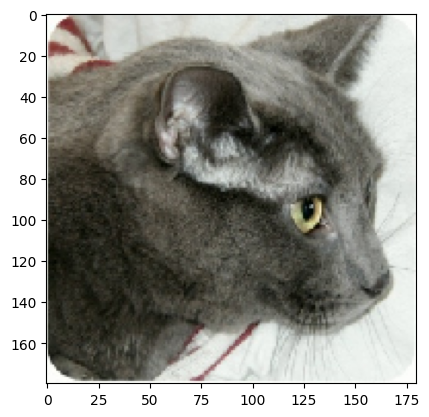

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")